In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
%matplotlib inline

# MINST Dataset

In [26]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [27]:
X, y = mnist["data"], mnist["target"]

In [28]:
X.shape, y.shape

((70000, 784), (70000,))

In [29]:
type(X)

pandas.core.frame.DataFrame

5


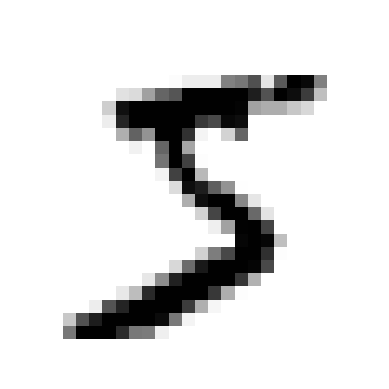

In [30]:
some_digit = X.iloc[0].values.reshape(28, -1)
plt.imshow(some_digit, cmap="binary")
plt.axis("off")
print(y[0])

In [31]:
type(y)

pandas.core.series.Series

In [32]:
# y => is categories list
# let's convert it to numbers
y = y.astype(np.uint8)
# MINST Is already splitted into train (6000), test
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

**it's already shuffled** => some training algorithms is sensetive if get simialr examples in row

# Multiclass Classifier

- also called "multinomial"
- some algorithms are capable of handling multiple class natively (SGD, Naiive Bayes, Random Forest)
- some are strictly handle binary classes (SVM, Logistic regression) however there's ways to handle that
- **Ways to Handle that:** (working if want to predict number for MINST)
    -  train 10 binary classifiers then choose the highest decision score ___OvR___ one versus the rest
    -  train one that classify between two classes (eg., distinguish one versus two) you will need then N(N-1)/2 $\approx$ 45 for "MINST".
        -  the one advantage that each model will train only on some part of Dataset ___OvO___ one versus one
        -  when you want to classify choose which class wins the most duels
  
> for some algorithms scale poorly with size of dataset (eg., SVM) here __OvO__ perfered
> 
> for other __OvR__

<div class="alert alert-block alert-info">
    **Info**>Scikit automatically know when you try to predict multi-class using binary classification algorithm and will use for you `OvO` or `OvR`.

</div>

In [33]:
#lets try SVM
from sklearn.svm import SVC 

In [34]:
svm_clf = SVC()

In [35]:
svm_clf.fit(X_train, y_train)

SVC()

In [48]:
some_digit = X.iloc[[0], :]
svm_clf.predict(some_digit)

array([5], dtype=uint8)

<div class="alert alert-block alert-info">
    
under the hood scikit used OvO strategy it trained 45 binary classifiers, got their decision scores for the image, and select class that won

</div>

In [50]:
# the highest score is the indeed '5'
svm_clf.decision_function(some_digit)

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
# store classes sorted by values
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
# lets use OneVersus Rest
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [53]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [54]:
ovr_clf.predict(some_digit)

array([5], dtype=uint8)

In [55]:
len(ovr_clf.estimators_)

10

In [57]:
#lets try SGD clf (schostic gradient)
from sklearn.linear_model import SGDClassifier

In [59]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [62]:
# notice: no need to use OvO or Ovr
sgd_clf.predict(some_digit) # >< wrong

array([3], dtype=uint8)

In [61]:
sgd_clf.decision_function(some_digit) # it really confused it was three or five (but three win)

array([[-19352.12485801, -24493.74955354, -11639.09897731,
          2455.40500663, -23345.75204705,   1907.8205031 ,
        -16319.76133126, -15906.27305829, -11934.73732813,
        -11168.12396029]])

In [63]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [64]:
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
sgd_scores

array([0.8696 , 0.87145, 0.86975])

In [70]:
sgd_scores.mean()
sgd_scores.std()

0.0008389808632435077

> according to book will get more accurate if it scaled 

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [67]:
sgd_scores_scaled = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
sgd_scores_scaled

array([0.8721 , 0.84645, 0.8707 ])

In [69]:
sgd_scores_scaled.mean()
sgd_scores_scaled.std()

0.011775421672091205

# Error Analysis

here we will assume the `SGDClassifier` is the best model & we want to optimize it by __analyzing errors__

In [68]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [71]:
from sklearn.metrics import confusion_matrix

In [72]:
conf_matrix = confusion_matrix(y_train, y_train_pred)

In [73]:
import seaborn as sns

<Axes: >

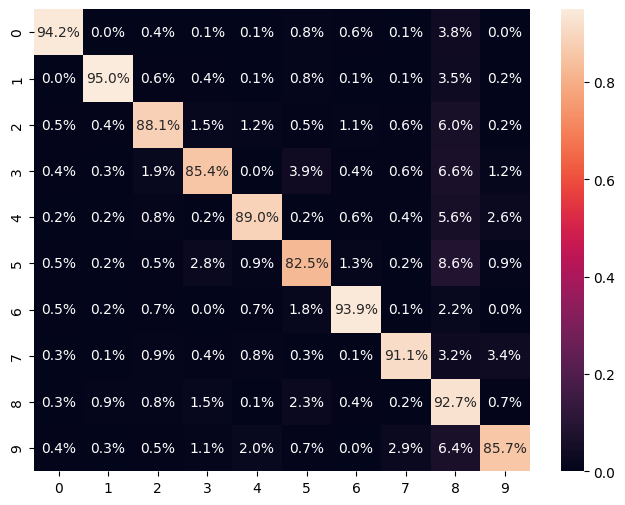

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt=".1%")

In [93]:
((conf_matrix / np.sum(conf_matrix, axis=1)).diagonal()).argsort()

array([5, 3, 9, 2, 4, 7, 8, 6, 0, 1], dtype=int64)

#### observations 
- it confuse (2 with  8) (3 with 8,5,9) (4 with 8,9) (5 with 8, 3) (6 with 8, 5) (7 with 9, 8) __ (9 with 8,7)
- it predict very poor with class sorted [5, 3, 9, 2, 4, 7, 8, 6, 0, 1]
- column of 8 is kinda bright => most images misclassified as "8" but row "8" is good (high recall low precision)
- 3, 5 get confused with each other
#### conculsions
solve problem of class "8"

#### possible solution
- engineer new featues (eg. #closed loops ) which will be in "8"=2
- gather more images that look like "8" but are not => to optimize it
- could preprocess image

In [167]:
def plot_digits(X, images_per_row=5):
    images_per_col = X.shape[0] // images_per_row
    
    img = np.ones((images_per_row * 28, images_per_col*28))
    for i, digit in enumerate(X.values):
        r, c = i // images_per_row, i % images_per_col
        img[r*28:r*28 + 28, c*28:c*28 + 28] = digit.reshape(28, 28)
        
    plt.imshow(img, cmap="binary")
    plt.axis("off")

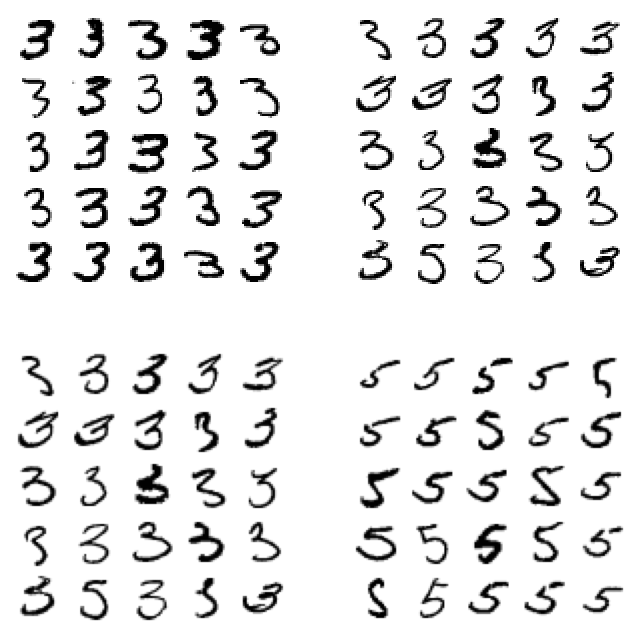

In [169]:
# lets look more on "3","5" problem
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25]) ;
plt.subplot(222); plot_digits(X_ab[:25]) ;
plt.subplot(223); plot_digits(X_ab[:25]) ;
plt.subplot(224); plot_digits(X_bb[:25]) ;

> even so some misclassified images will be misclassified by human
but mostly not

- classifier behave so poor as it's simple linear model
- which just assign a weight per feature "pixel" per class -> then -> sum weighted pixel intensities to get score for each class
- and since "3", "5" are different by few pixels -> this model confuse them easily
- the only difference between "3" and "5" is one arc -> if three or five shift or rotate a little bit it confuse them

#### conculsion
could use Hough Transform to make sure its centered & not rotated